<a href="https://colab.research.google.com/github/Sannevastaveren/Donders_internship/blob/main/Notebooks/Synchronization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synchronization

There is 2 methods


1.   LED cross correlation

*   Harder option
*   Does not work well with only 2 states

2.   Timestamp extraction

*   Easier method if pointgrey and open ephys timestamps are connected
*   Not all files have the timestamp files









## Mounting & Variables

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Video cutting tool

In [ ]:
#@title <font size="5">← ឵឵<i>Upgrade FFmpeg to v4.2.2</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


### Installation of extra functions

In [1]:
import os, sys, re


def frames_to_timecode(frames,framerate=30):
    """ Makes a timecode in the format HH:MM:SS:MS using framenumber and rate

    Keyword arguments:
    frames -- int of the frame number you want to convert to a time
    framerate -- int ofthe frame rate of the camera (default 30)
    """
    return'{0:02d}:{1:02d}:{2:02d}:{3:02d}'.format(int(frames / (3600*framerate)),
                                                     int(frames / (60*framerate) % 60),
                                                    int(frames / framerate % 60),
                                                    int(frames % framerate))
    return b

# returns list with file names (0 = frameNumbers, 1 = timestamps, 2 = ledstatus, 3 = video)
def make_pg_files(date_serial):
  """ Makes a dictionary with the files of this date serial,
      dictionary looks like the following:
      {0 = frameNumbers, 1 = timestamps, 2 = ledstatus, 3 = video}

    Keyword arguments:
    date_serial -- string with date serial given in a set of pointgrey files
                   example: file name = PointGreyTimestamps2020-04-27T10_40_02.csv
                            the date serial would be "2020-04-27T10_40_02"

  """
  camera = 'PointGrey'
  types_files = ['Framenumber','Timestamps', 'LEDStatus']
  f_type = '.csv'
  v_type = '.avi'
  files = []
  for t in types_files:
    n = camera+t+date_serial+f_type
    files.append(n)
  files.append(camera+'Video'+date_serial+'downsampled'+v_type)
  return files


def get_seconds(b_list):
    """ calculates the seconds from a list of timestamps in format HH:MM:SS

    Keyword arguments:
    b_list -- list of timestamp pairs looks like the following:
              [01:55:34-01:58:56,..]

  """
    times_list = []
    for l in b_list:
        s_list = []
        for t in l:
            hh, mm, ss, ms = t.split(':')
            s = int(hh) * 3600 + int(mm) * 60 + int(ss)
            s_list.append(s)
        time = str(s_list[0]) + '-' + str(s_list[1])
        times_list.append(time)
    print(times_list)
    return times_list
  
def load_data_into_dataframe(data):
    """ Makes a pandas dataframe for the data and another for the timestamps
    in the open ephys data dictionary
    Keyword arguments:
    data -- Dictionary gathered from the open ephys code 
    after loading the ADC files
   """
   samples = np.array(data['data'])
   timestamps = np.array(data['timestamps'])
   DF_samples = pd.DataFrame(samples)
   DF_timestamps= pd.DataFrame(timestamps)
   return DF_samples, DF_timestamps


def converttime(time):
      """ Takes an array of Pointgrey timestamps and decodes it into seconds
      Keyword arguments:
      author: goncaloclopes
      time -- array of pointgrey timestamps
      """
      #offset = time & 0xFFF
      time = time.to_numpy()
      cycle1 = (time >> 12) & 0x1FFF
      cycle2 = (time >> 25) & 0x7F
      seconds = cycle2 + cycle1 / 8000.
      return seconds

def uncycle(time):
      """ Takes an array of converted Pointgrey timestamps 
      and uncycles them so it correlates to the actual time
      author: goncaloclopes
      Keyword arguments:
      time -- array of pointgrey decoded timestamps
      """
      cycles = np.insert(np.diff(time) < 0, 0, False)
      cycleindex = np.cumsum(cycles)
      return time + cycleindex * 128

def convert_and_uncycle_timestamps(df):
    """ Takes a dataframe of Pointgrey timestamps 
      and converts and uncycles them so it correlates to the actual time
      Keyword arguments:
      df -- Dataframe of pointgrey timestamps
    """
    df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
    modDfObj = df.apply(converttime)
    uncycledDF = modDfObj.apply(uncycle)
    return uncycledDF

def dividething(n):
    """ divide by 30k to make up for sampling rate
    """
    n = n/30000
    return n

def calculate_pixel_size(dpi):
  """ calculate the size of a pixel based on the dpi of a picture
  """
  #dpi is the pixel density or dots per inch.
  #96 dpi means there are 96 pixels per inch.
  #1 inch is equal to 25.4 millimeters.
  inch = 25.4
  pixel_size= dpi/inch
  return pixel_size

def cut(video_file_path, start_time, end_time):
  """ cuts the video using ffmpeg using the start and end time and the video
  Keyword arguments:
  video_file_path -- full path to the video
  start_time -- string of time in HH:MM:SS:ff format
  end_time -- string of time in HH:MM:SS:ff format
  """
  output_file_path = re.search("^[\/].+\/", video_file_path)
  output_file_path_raw = output_file_path.group(0)
  delsplit = re.search("\/(?:.(?!\/))+$", video_file_path)
  filename = re.sub("^[\/]", "", delsplit.group(0))
  filename_raw = re.sub(".{4}$", "", filename)
  file_extension = re.search(".{3}$", filename)
  file_extension_raw = file_extension.group(0)

  os.environ['inputFile'] = video_file_path
  os.environ['outputPath'] = output_file_path_raw
  os.environ['startTime'] = start_time
  os.environ['endTime'] = end_time
  os.environ['fileName'] = filename_raw
  os.environ['fileExtension'] = file_extension_raw

  !ffmpeg -hide_banner -i "$inputFile" -ss "$startTime" -to "$endTime" -c copy "$outputPath"/"$fileName"-TRIM."$fileExtension"

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug  3 15:18:38 2014
@author: Dan Denman and Josh Siegle
Loads .continuous, .events, and .spikes files saved from the Open Ephys GUI
Usage:
    import OpenEphys
    data = OpenEphys.load(pathToFile) # returns a dict with data, timestamps, etc.
"""

import os
import numpy as np
import scipy.signal
import scipy.io
import time
import struct
from copy import deepcopy

# constants
NUM_HEADER_BYTES = 1024
SAMPLES_PER_RECORD = 1024
BYTES_PER_SAMPLE = 2
RECORD_SIZE = 4 + 8 + SAMPLES_PER_RECORD * BYTES_PER_SAMPLE + 10 # size of each continuous record in bytes
RECORD_MARKER = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 255])

# constants for pre-allocating matrices:
MAX_NUMBER_OF_SPIKES = int(1e6)
MAX_NUMBER_OF_RECORDS = int(1e6)
MAX_NUMBER_OF_EVENTS = int(1e6)

def load(filepath, dtype = float):

    # redirects to code for individual file types
    if 'continuous' in filepath:
        data = loadContinuous(filepath, dtype)
    elif 'spikes' in filepath:
        data = loadSpikes(filepath)
    elif 'events' in filepath:
        data = loadEvents(filepath)
    else:
        raise Exception("Not a recognized file type. Please input a .continuous, .spikes, or .events file")

    return data

def loadFolder(folderpath, dtype = float, **kwargs):

    # load all continuous files in a folder

    data = { }

    # load all continuous files in a folder
    if 'channels' in kwargs.keys():
        filelist = ['100_CH'+x+'.continuous' for x in map(str,kwargs['channels'])]
    else:
        filelist = os.listdir(folderpath)

    t0 = time.time()
    numFiles = 0

    for i, f in enumerate(filelist):
        if '.continuous' in f:
            data[f.replace('.continuous','')] = loadContinuous(os.path.join(folderpath, f), dtype = dtype)
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data

def loadFolderToArray(folderpath, channels = 'all', chprefix = 'CH',
                      dtype = float, session = '0', source = '100'):
    '''Load continuous files in specified folder to a single numpy array. By default all
    CH continous files are loaded in numerical order, ordering can be specified with
    optional channels argument which should be a list of channel numbers.'''

    if channels == 'all':
        channels = _get_sorted_channels(folderpath, chprefix, session, source)

    if session == '0':
        filelist = [source + '_'+chprefix + x + '.continuous' for x in map(str,channels)]
    else:
        filelist = [source + '_'+chprefix + x + '_' + session + '.continuous' for x in map(str,channels)]

    t0 = time.time()
    numFiles = 1

    channel_1_data = loadContinuous(os.path.join(folderpath, filelist[0]), dtype)['data']

    n_samples  = len(channel_1_data)
    n_channels = len(filelist)

    data_array = np.zeros([n_samples, n_channels], dtype)
    data_array[:,0] = channel_1_data

    for i, f in enumerate(filelist[1:]):
            data_array[:, i + 1] = loadContinuous(os.path.join(folderpath, f), dtype)['data']
            numFiles += 1

    print(''.join(('Avg. Load Time: ', str((time.time() - t0)/numFiles),' sec')))
    print(''.join(('Total Load Time: ', str((time.time() - t0)),' sec')))

    return data_array

def loadContinuous(filepath, dtype = float):

    assert dtype in (float, np.int16), \
      'Invalid data type specified for loadContinous, valid types are float and np.int16'

    print("Loading continuous data...")

    ch = { }

    #read in the data
    f = open(filepath,'rb')

    fileLength = os.fstat(f.fileno()).st_size

    # calculate number of samples
    recordBytes = fileLength - NUM_HEADER_BYTES
    if  recordBytes % RECORD_SIZE != 0:
        raise Exception("File size is not consistent with a continuous file: may be corrupt")
    nrec = recordBytes // RECORD_SIZE
    nsamp = nrec * SAMPLES_PER_RECORD
    # pre-allocate samples
    samples = np.zeros(nsamp, dtype)
    timestamps = np.zeros(nrec)
    recordingNumbers = np.zeros(nrec)
    indices = np.arange(0, nsamp + 1, SAMPLES_PER_RECORD, np.dtype(np.int64))

    header = readHeader(f)

    recIndices = np.arange(0, nrec)

    for recordNumber in recIndices:

        timestamps[recordNumber] = np.fromfile(f,np.dtype('<i8'),1) # little-endian 64-bit signed integer
        N = np.fromfile(f,np.dtype('<u2'),1)[0] # little-endian 16-bit unsigned integer

        #print index

        if N != SAMPLES_PER_RECORD:
            raise Exception('Found corrupted record in block ' + str(recordNumber))

        recordingNumbers[recordNumber] = (np.fromfile(f,np.dtype('>u2'),1)) # big-endian 16-bit unsigned integer

        if dtype == float: # Convert data to float array and convert bits to voltage.
            data = np.fromfile(f,np.dtype('>i2'),N) * float(header['bitVolts']) # big-endian 16-bit signed integer, multiplied by bitVolts
        else:  # Keep data in signed 16 bit integer format.
            data = np.fromfile(f,np.dtype('>i2'),N)  # big-endian 16-bit signed integer
        samples[indices[recordNumber]:indices[recordNumber+1]] = data

        marker = f.read(10) # dump

    #print recordNumber
    #print index

    ch['header'] = header
    ch['timestamps'] = timestamps
    ch['data'] = samples  # OR use downsample(samples,1), to save space
    ch['recordingNumber'] = recordingNumbers
    f.close()
    return ch

def loadSpikes(filepath):

    '''
    Loads spike waveforms and timestamps from filepath (should be .spikes file)
    '''

    data = { }

    print('loading spikes...')

    f = open(filepath, 'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .spikes files with version 0.4 or higher')

    data['header'] = header
    numChannels = int(header['num_channels'])
    numSamples = 40 # **NOT CURRENTLY WRITTEN TO HEADER**

    spikes = np.zeros((MAX_NUMBER_OF_SPIKES, numSamples, numChannels))
    timestamps = np.zeros(MAX_NUMBER_OF_SPIKES)
    source = np.zeros(MAX_NUMBER_OF_SPIKES)
    gain = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    thresh = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    sortedId = np.zeros((MAX_NUMBER_OF_SPIKES, numChannels))
    recNum = np.zeros(MAX_NUMBER_OF_SPIKES)

    currentSpike = 0

    while f.tell() < os.fstat(f.fileno()).st_size:
        eventType = np.fromfile(f, np.dtype('<u1'),1) #always equal to 4, discard
        timestamps[currentSpike] = np.fromfile(f, np.dtype('<i8'), 1)
        software_timestamp = np.fromfile(f, np.dtype('<i8'), 1)
        source[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)
        numChannels = np.fromfile(f, np.dtype('<u2'), 1)[0]
        numSamples = np.fromfile(f, np.dtype('<u2'), 1)[0]
        sortedId[currentSpike] = np.fromfile(f, np.dtype('<u2'),1)
        electrodeId = np.fromfile(f, np.dtype('<u2'),1)
        channel = np.fromfile(f, np.dtype('<u2'),1)
        color = np.fromfile(f, np.dtype('<u1'), 3)
        pcProj = np.fromfile(f, np.float32, 2)
        sampleFreq = np.fromfile(f, np.dtype('<u2'),1)

        waveforms = np.fromfile(f, np.dtype('<u2'), numChannels*numSamples)
        gain[currentSpike,:] = np.fromfile(f, np.float32, numChannels)
        thresh[currentSpike,:] = np.fromfile(f, np.dtype('<u2'), numChannels)
        recNum[currentSpike] = np.fromfile(f, np.dtype('<u2'), 1)

        waveforms_reshaped = np.reshape(waveforms, (numChannels, numSamples))
        waveforms_reshaped = waveforms_reshaped.astype(float)
        waveforms_uv = waveforms_reshaped

        for ch in range(numChannels):
            waveforms_uv[ch, :] -= 32768
            waveforms_uv[ch, :] /= gain[currentSpike, ch]*1000

        spikes[currentSpike] = waveforms_uv.T

        currentSpike += 1

    data['spikes'] = spikes[:currentSpike,:,:]
    data['timestamps'] = timestamps[:currentSpike]
    data['source'] = source[:currentSpike]
    data['gain'] = gain[:currentSpike,:]
    data['thresh'] = thresh[:currentSpike,:]
    data['recordingNumber'] = recNum[:currentSpike]
    data['sortedId'] = sortedId[:currentSpike]

    return data


def loadEvents(filepath):

    data = { }

    print('loading events...')

    f = open(filepath,'rb')
    header = readHeader(f)

    if float(header[' version']) < 0.4:
        raise Exception('Loader is only compatible with .events files with version 0.4 or higher')

    data['header'] = header

    index = -1

    channel = np.zeros(MAX_NUMBER_OF_EVENTS)
    timestamps = np.zeros(MAX_NUMBER_OF_EVENTS)
    sampleNum = np.zeros(MAX_NUMBER_OF_EVENTS)
    nodeId = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventType = np.zeros(MAX_NUMBER_OF_EVENTS)
    eventId = np.zeros(MAX_NUMBER_OF_EVENTS)
    recordingNumber = np.zeros(MAX_NUMBER_OF_EVENTS)

    while f.tell() < os.fstat(f.fileno()).st_size:

        index += 1

        timestamps[index] = np.fromfile(f, np.dtype('<i8'), 1)
        sampleNum[index] = np.fromfile(f, np.dtype('<i2'), 1)
        eventType[index] = np.fromfile(f, np.dtype('<u1'), 1)
        nodeId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        eventId[index] = np.fromfile(f, np.dtype('<u1'), 1)
        channel[index] = np.fromfile(f, np.dtype('<u1'), 1)
        recordingNumber[index] = np.fromfile(f, np.dtype('<u2'), 1)

    data['channel'] = channel[:index]
    data['timestamps'] = timestamps[:index]
    data['eventType'] = eventType[:index]
    data['nodeId'] = nodeId[:index]
    data['eventId'] = eventId[:index]
    data['recordingNumber'] = recordingNumber[:index]
    data['sampleNum'] = sampleNum[:index]

    return data

def readHeader(f):
    header = { }
    h = f.read(1024).decode().replace('\n','').replace('header.','')
    for i,item in enumerate(h.split(';')):
        if '=' in item:
            header[item.split(' = ')[0]] = item.split(' = ')[1]
    return header

def downsample(trace,down):
    downsampled = scipy.signal.resample(trace,np.shape(trace)[0]/down)
    return downsampled

def pack(folderpath,source='100',**kwargs):
#convert single channel open ephys channels to a .dat file for compatibility with the KlustaSuite, Neuroscope and Klusters
#should not be necessary for versions of open ephys which write data into HDF5 format.
#loads .continuous files in the specified folder and saves a .DAT in that folder
#optional arguments:
#   source: string name of the source that openephys uses as the prefix. is usually 100, if the headstage is the first source added, but can specify something different
#
#   data: pre-loaded data to be packed into a .DAT
#   dref: int specifying a channel # to use as a digital reference. is subtracted from all channels.
#   order: the order in which the .continuos files are packed into the .DAT. should be a list of .continious channel numbers. length must equal total channels.
#   suffix: appended to .DAT filename, which is openephys.DAT if no suffix provided.

    #load the openephys data into memory
    if 'data' not in kwargs.keys():
        if 'channels' not in kwargs.keys():
            data = loadFolder(folderpath, dtype = np.int16)
        else:
            data = loadFolder(folderpath, dtype = np.int16, channels=kwargs['channels'])
    else:
        data = kwargs['data']
    #if specified, do the digital referencing
    if 'dref' in kwargs.keys():
        ref =load(os.path.join(folderpath,''.join((source,'_CH',str(kwargs['dref']),'.continuous'))))
        for i,channel in enumerate(data.keys()):
            data[channel]['data'] = data[channel]['data'] - ref['data']
    #specify the order the channels are written in
    if 'order' in kwargs.keys():
        order = kwargs['order']
    else:
        order = list(data)
    #add a suffix, if one was specified
    if 'suffix' in kwargs.keys():
        suffix=kwargs['suffix']
    else:
        suffix=''

    #make a file to write the data back out into .dat format
    outpath = os.path.join(folderpath,''.join(('openephys',suffix,'.dat')))
    out = open(outpath,'wb')

    #go through the data and write it out in the .dat format
    #.dat format specified here: http://neuroscope.sourceforge.net/UserManual/data-files.html
    channelOrder = []
    print(''.join(('...saving .dat to ',outpath,'...')))
    random_datakey = next(iter(data))
    bar = ProgressBar(len(data[random_datakey]['data']))
    for i in range(len(data[random_datakey]['data'])):
        for j in range(len(order)):
            if source in random_datakey:
                ch = data[order[j]]['data']
            else:
                ch = data[''.join(('CH',str(order[j]).replace('CH','')))]['data']
            out.write(struct.pack('h',ch[i]))#signed 16-bit integer
            #figure out which order this thing packed the channels in. only do this once.
            if i == 0:
                channelOrder.append(order[j])
        #update how mucb we have list
        if i%(len(data[random_datakey]['data'])/100)==0:
            bar.animate(i)
    out.close()
    print(''.join(('order: ',str(channelOrder))))
    print(''.join(('.dat saved to ',outpath)))

#**********************************************************
# progress bar class used to show progress of pack()
    #stolen from some post on stack overflow
import sys
try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
class ProgressBar:
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self,)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
#*************************************************************

def pack_2(folderpath, filename = '', channels = 'all', chprefix = 'CH',
           dref = None, session = '0', source = '100'):

    '''Alternative version of pack which uses numpy's tofile function to write data.
    pack_2 is much faster than pack and avoids quantization noise incurred in pack due
    to conversion of data to float voltages during loadContinous followed by rounding
    back to integers for packing.
    filename: Name of the output file. By default, it follows the same layout of continuous files,
              but without the channel number, for example, '100_CHs_3.dat' or '100_ADCs.dat'.
    channels:  List of channel numbers specifying order in which channels are packed. By default
               all CH continous files are packed in numerical order.
    chprefix:  String name that defines if channels from headstage, auxiliary or ADC inputs
               will be loaded.
    dref:  Digital referencing - either supply a channel number or 'ave' to reference to the
           average of packed channels.
    source: String name of the source that openephys uses as the prefix. It is usually 100,
            if the headstage is the first source added, but can specify something different.
    '''

    data_array = loadFolderToArray(folderpath, channels, chprefix, np.int16, session, source)

    if dref:
        if dref == 'ave':
            print('Digital referencing to average of all channels.')
            reference = np.mean(data_array,1)
        else:
            print('Digital referencing to channel ' + str(dref))
            if channels == 'all':
                channels = _get_sorted_channels(folderpath, chprefix, session, source)
            reference = deepcopy(data_array[:,channels.index(dref)])
        for i in range(data_array.shape[1]):
            data_array[:,i] = data_array[:,i] - reference

    if session == '0': session = ''
    else: session = '_'+session

    if not filename: filename = source + '_' + chprefix + 's' + session + '.dat'
    print('Packing data to file: ' + filename)
    data_array.tofile(os.path.join(folderpath,filename))


def _get_sorted_channels(folderpath, chprefix='CH', session='0', source='100'):
    Files = [f for f in os.listdir(folderpath) if '.continuous' in f
                                               and '_'+chprefix in f
                                               and source in f]

    if session == '0':
        Files = [f for f in Files if len(f.split('_')) == 2]
        Chs = sorted([int(f.split('_'+chprefix)[1].split('.')[0]) for f in Files])
    else:
        Files = [f for f in Files if len(f.split('_')) == 3
                                  and f.split('.')[0].split('_')[2] == session]

        Chs = sorted([int(f.split('_'+chprefix)[1].split('_')[0]) for f in Files])
    return(Chs)



## LED cross correlation

### processing

Loading continuous data...
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.364, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.635, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.366, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.371, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.628, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.618, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.388, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.611, 0.0, 0.0

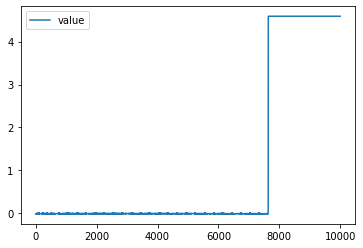

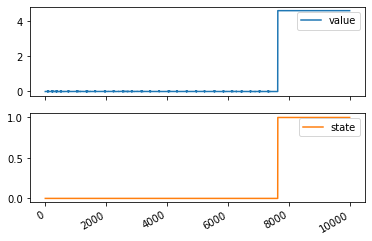

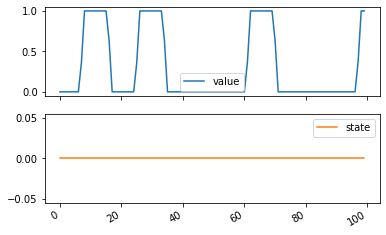

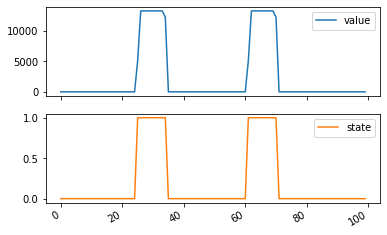

In [ ]:
import pandas as pd
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce

import os


def LED_processing(file_path, date_serial, ADC='1', ADC_loc=''):
  """ processes the two LED files (continuous and pointgrey) to be 
  the same sampling rate
  Keyword arguments:
  file_path -- full path to the directory where the files are located
  date_serial -- string with date serial given in a set of pointgrey files
                 example: file name = PointGreyTimestamps2020-04-27T10_40_02.csv
                          the date serial would be "2020-04-27T10_40_02"
  ADC -- string of the channel number you want to use (default = '1')
  ADC_loc -- location of ADC files if different (default= '')

  """
    # make graphs inline otherwise notebook will crash
  %matplotlib inline

  # make file variables
  ADC_file = ADC_loc+'/100_ADC'+ADC+'_0.continuous'
  Pointgrey_files = make_pg_files(date_serial)
  LED_file = Pointgrey_files[2]
  VIDEO_file = Pointgrey_files[3]
  
  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_led = pd.read_csv(file_path+LED_file, header=None)


  # DLC variables
  %matplotlib inline

  DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)
  DF_ADC_samples['state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(0,1), 'state'] = 0
  DF_ADC_samples.loc[DF_ADC_samples.value.between(1,5), 'state'] = 1
  group_size = 1000
  lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

  bla = []
  for df in lst:
    m = df["state"].mean()
    bla.append(m)

  blabla = pd.DataFrame(bla)
  blabla.rename(columns={0: 'value'}, inplace=True)
  blabla['state'] = 0
  blabla.iloc[0:100].plot.line(subplots=True)
  blabla.loc[blabla['value'] <= 0, 'state'] = 0
  blabla.loc[blabla['value'] > 0, 'state'] = 1

  DF_p_led.rename(columns={0: 'value'}, inplace=True)
  DF_p_led['state'] = 0
  DF_p_led.loc[DF_p_led['value'] <= 500, 'state'] = 0
  DF_p_led.loc[DF_p_led['value'] > 500, 'state'] = 1
  DF_p_led.iloc[0:100].plot.line(subplots=True)
  print(blabla.value.tolist())
  trial = blabla.state.astype(str).str.cat()
  whole = DF_p_led['state'].astype(str).str.cat()
  return whole, trial


whole,trial = LED_processing(file_path='/content/drive/My Drive/Stage/ADC_trial1/',
                             date_serial='2020-05-04T10_34_08')

### cross correlation

attempt at cross correlation using np correlate, has not yet given any usefull results

ValueError: ignored

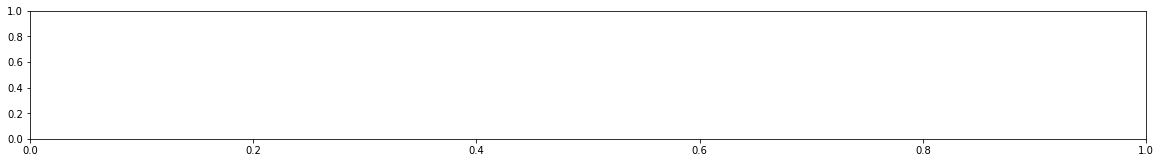

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

whole_list =  list(map(int, list(whole)))
trial_list = list(map(int, list(trial)))

from itertools import repeat
trial_list = trial_list + list(repeat(0, len(whole_list)-len(trial_list)))

Fs=100
ts = np.arange(0,len(whole_list))

plt.figure(figsize=(20,8))
plt.subplot(3,1,1)
plt.plot(ts,trial_list)
plt.subplot(3,1,2)
plt.plot(ts,whole_list)


corr = np.correlate(whole_list, trial_list,'same')

print(np.argmax(corr)) #this should be where correlation reaches its maximum value, and where the functions are most "similar"

plt.subplot(3,1,3)
plt.plot(corr, 'r')


### testing
Just some tests on led cross correlation to figure out if it works or not

12


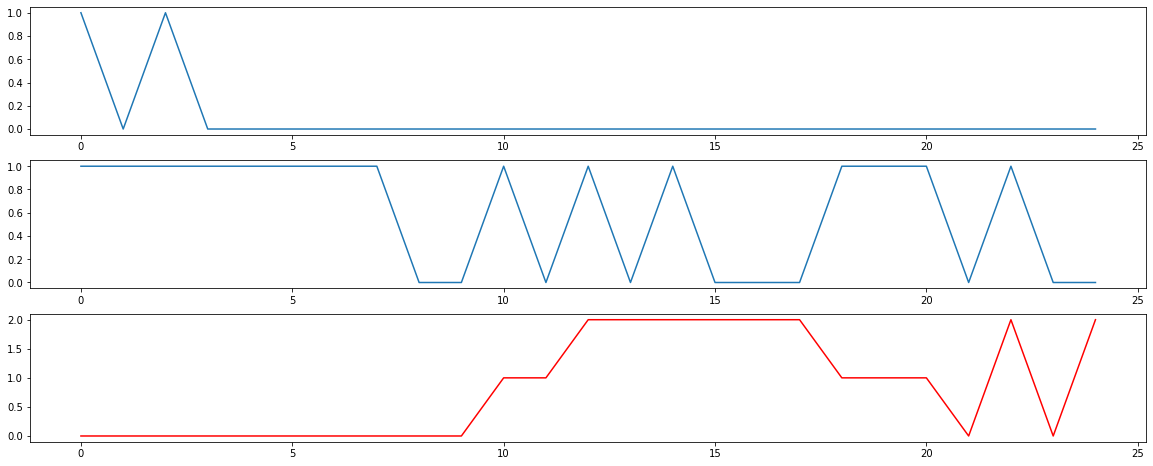

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

whole_list =  [1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,1,0,1,0,0]
trial_list =  [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Fs=100
ts = np.arange(0,len(whole_list))

plt.figure(figsize=(20,8))
plt.subplot(3,1,1)
plt.plot(ts,trial_list)
plt.subplot(3,1,2)
plt.plot(ts,whole_list)

corr = np.correlate(whole_list, trial_list,'same')

print(np.argmax(corr)) #this should be where correlation reaches its maximum value, and where the functions are most "similar"

plt.subplot(3,1,3)
plt.plot(corr, 'r')


In [ ]:
file_path = '/content/drive/My Drive/Stage/synch_test/'
ADC_file = 'Trial1/100_ADC1_0.continuous'
LED_file = 'PointGreyLEDStatus2018-07-30T11_24_12.csv'
TIME_file = 'PointGreyTimestamps2018-07-30T11_24_12.csv'

data = load(file_path+ADC_file)
DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)

DF_ADC_samples.rename(columns={0 : 'value'}, inplace=True)

DF_ADC_samples.iloc[0:10000].plot.line(subplots=True)
group_size = 1000
lst = [DF_ADC_samples.iloc[i:i+group_size] for i in range(0,len(DF_ADC_samples)-group_size+1,group_size)]

bla = []
for df in lst:
  m = df["value"].mean()
  bla.append(m)

In [ ]:
import pandas as pd
DF_p_led = pd.read_csv('/content/drive/My Drive/Stage/PointGreyLEDStatus2019-10-14T09_35_30.csv', header=None)
DF_p_frame = pd.read_csv('/content/drive/My Drive/Stage/PointGreyFramenumber2019-10-14T09_35_30.csv', header=None)
DF_p_time = pd.read_csv('/content/drive/My Drive/Stage/PointGreyTimestamps2019-10-14T09_35_30.csv', header=None)

print(len(DF_p_led))
print(len(DF_p_frame))
print(len(DF_p_time))

print(DF_p_frame.diff())

91487


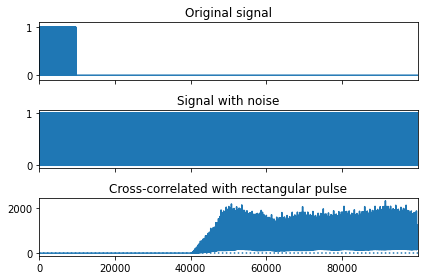

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
from itertools import repeat
whole_list =  list(map(int, list(whole)))[0:100000]
trial_list = list(map(int, list(trial)))[0:100000]
trial_list = trial_list + list(repeat(0, len(whole_list)-len(trial_list)))
#sig = np.repeat(trial_list, 70.949742384525 )
corr = signal.correlate( whole_list,trial_list, mode='same', method='fft') 
print(np.argmax(corr)) 

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(trial_list)
ax_orig.set_title('Original signal')
ax_noise.plot(whole_list)
ax_noise.set_title('Signal with noise')
ax_corr.plot(corr)
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

## Timestamp extraction

### Method

Loading continuous data...
                0
0      81392700.0
1      81393724.0
2      81394748.0
3      81395772.0
4      81396796.0
...           ...
10799  92450876.0
10800  92451900.0
10801  92452924.0
10802  92453948.0
10803  92454972.0

[10804 rows x 1 columns]
81392700.0 - 92454972.0
ADC time:  00:45:13.090000 - 00:51:21.832400
poingrey with ADC time:  00:45:15.459500 - 00:51:24.387625
difference between ADC time and pg with ADC time:  0:00:02.369500 - 0:00:02.555225
difference between ADC time and pg with ADC time:  -1 day, 23:59:57.630500 - -1 day, 23:59:57.444775
difference of the difference:  0:00:00.185725
difference of the difference:  -1 day, 23:59:59.814275

0    5.148
dtype: float64
Loading continuous data...
                0
0     173673000.0
1     173674024.0
2     173675048.0
3     173676072.0
4     173677096.0
...           ...
9311  183207464.0
9312  183208488.0
9313  183209512.0
9314  183210536.0
9315  183211560.0

[9316 rows x 1 columns]
173673000.0 - 183211560

"timestamp_extraction(file_path = '/content/drive/My Drive/Stage/ADC_trial1/',\n                     date_serial = '2020-05-04T10_34_07',\n                     ADC =  '1' ,\n                     ADC_loc = '')"

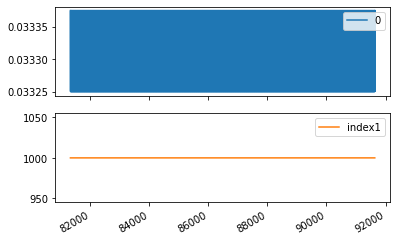

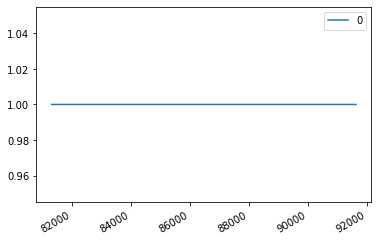

In [ ]:
import pandas as pd
import time
import os
from datetime import datetime

def timestamp_extraction(file_path, date_serial, ADC='1', ADC_loc=''):
  """ Extraction of video based on timestamps of continuous and pointgrey files,
  Keyword arguments:
  file_path -- full path to the directory where the files are located
  date_serial -- string with date serial given in a set of pointgrey files
                 example: file name = PointGreyTimestamps2020-04-27T10_40_02.csv
                          the date serial would be "2020-04-27T10_40_02"
  ADC -- string of the channel number you want to use (default = '1')
  ADC_loc -- location of ADC files if different (default= '')
  """
  # make graphs inline otherwise notebook will crash
  %matplotlib inline

  # make file variables
  ADC_file = ADC_loc+'/100_ADC'+ADC+'_0.continuous'
  Pointgrey_files = make_pg_files(date_serial)
  FRAME_file = Pointgrey_files[0]
  TIME_file = Pointgrey_files[1]
  VIDEO_file = Pointgrey_files[3]
  
  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_frames = pd.read_csv(file_path+FRAME_file, header=None)
  DF_p_timestamps = pd.read_csv(file_path+TIME_file, header=None)
  DF_p_timestamps = convert_and_uncycle_timestamps(DF_p_timestamps)
  DF_p_timestamps = DF_p_timestamps.apply(lambda x : x - DF_p_timestamps[0][0])

  # find the starting timestamp and stopping timestamp in the continuous files
  s = DF_ADC_timestamps[0][0]
  st = DF_ADC_timestamps.iloc[-1][0]
  print(s,'-',st)
  # multiply this number by 1000 to make it comparable to 
  # the continuous timestamps
  # (continuous file timestamps are sample numbers)
  DF_p_timestamps['index1'] = DF_p_timestamps.index*1000

  # find the closest value in the pointgrey file 
  # to the start and stop timestamp
  # (this is needed as the continuous files has a higher sampling rate and thus
  #  gives a more precise number than the index)
  c_s = DF_p_timestamps.iloc[(DF_p_timestamps['index1']-s).abs().argsort()[:1]].index.tolist()
  c_st = DF_p_timestamps.iloc[(DF_p_timestamps['index1']-st).abs().argsort()[:1]].index.tolist()
  
  # make a subset of the trial data
  sep_t = DF_p_timestamps.iloc[c_s[0]:c_st[0]]
  # convert the pointgrey timestamps in seconds to HH:MM:SS:ff format
  start = pd.to_datetime(DF_p_timestamps[0].iloc[c_s[0]], unit='s').strftime('%H:%M:%S.%f')
  stop = pd.to_datetime(DF_p_timestamps[0].iloc[c_st[0]], unit='s').strftime('%H:%M:%S.%f')

  # print results and a comparison to the old method I used
  print('ADC time: ',pd.to_datetime(s/30000, unit='s').strftime('%H:%M:%S.%f'),'-',pd.to_datetime(st/30000, unit='s').strftime('%H:%M:%S.%f'))
  print('poingrey with ADC time: ', start, '-', stop)
  #------------------------------------------------------------------------------------------------------------
  start_d = datetime.strptime(start, '%H:%M:%S.%f')
  stop_d = datetime.strptime(stop, '%H:%M:%S.%f')
  start_da = datetime.strptime(pd.to_datetime(s/30000, unit='s').strftime('%H:%M:%S.%f'), '%H:%M:%S.%f')
  stop_da = datetime.strptime(pd.to_datetime(st/30000, unit='s').strftime('%H:%M:%S.%f'), '%H:%M:%S.%f')
  print('difference between ADC time and pg with ADC time: ', start_d-start_da, '-', stop_d-stop_da)
  print('difference between ADC time and pg with ADC time: ', start_da-start_d, '-', stop_da-stop_d)
  print('difference of the difference: ', (stop_d-stop_da)-(start_d-start_da))
  print('difference of the difference: ', (start_d-start_da)-(stop_d-stop_da))
  print('')
  
  #------------------------------------------------------------------------------------------------------------
  # make a subset of the trial data in the frames file
  sep_f = DF_p_frames.iloc[c_s[0]:c_st[0]]

  # plot the trial data to check for disturbances
  sep_t.diff().plot.line(subplots=True)
  sep_f.diff().plot.line(subplots=True)

  # cut the video using the start and stop time 
  cut(video_file_path=file_path+VIDEO_file, start_time= start, end_time=stop)

timestamp_extraction(file_path = '/content/drive/My Drive/Stage/synch_test/',
                     date_serial = '2018-07-30T11_24_12',
                     ADC =  '1' ,
                     ADC_loc = 'Trial1')

timestamp_extraction(file_path = '/content/drive/My Drive/Stage/synch_test/',
                     date_serial = '2018-07-30T11_24_12',
                     ADC =  '1' ,
                     ADC_loc = 'Trial2')

timestamp_extraction(file_path = '/content/drive/My Drive/Stage/synch_test/',
                     date_serial = '2018-07-30T11_24_12',
                     ADC =  '1' ,
                     ADC_loc = '2018-07-30_15-34-58_Trial5')

timestamp_extraction(file_path = '/content/drive/My Drive/Stage/',
                     date_serial = '2019-10-14T09_35_30',
                     ADC =  '1' ,
                     ADC_loc = '')
                     
"""timestamp_extraction(file_path = '/content/drive/My Drive/Stage/ADC_trial1/',
                     date_serial = '2020-05-04T10_34_07',
                     ADC =  '1' ,
                     ADC_loc = '')"""

### Testing
Some testing and older methods of the timestamp synchronization

In [ ]:
import pandas as pd
import time
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import scenedetect.frame_timecode as sce
import deeplabcut
import os


def main():
  # DLC variables
  %matplotlib inline
  ProjectFolderName = 'Stage/sk_test-sanne-2021-09-08'
  VideoType = 'avi' 
  # video path 
  videofile_path = '/content/drive/My Drive/'+ProjectFolderName+'/videos/'
  videofile_path
  # config file
  path_config_file = '/content/drive/My Drive/'+ProjectFolderName+'/config.yaml'
  path_config_file

  # make file variables
  file_path = '/content/drive/My Drive/Stage/ADC_trial1/'
  ADC_file = '100_ADC1_0.continuous'
  FRAME_file = 'PointGreyFramenumber2020-05-04T10_34_07.csv'
  TIME_file = 'PointGreyTimestamps2020-05-04T10_34_07.csv'
  VIDEO_file = 'PointGreyVideo2018-07-30T11_24_12downsampled.avi'
  analysis_file = '/content/drive/My Drive/Stage/trail_1_whiteDLC_resnet50_downsampled_trackerSep16shuffle1_180000.csv'
  
  # load in data as dataframes
  data = load(file_path+ADC_file)
  DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
  DF_p_led = pd.read_csv(file_path+LED_file, header=None)
  DF_p_timestamps = pd.read_csv(file_path+TIME_file, header=None)
  DF_analysis = pd.read_csv(analysis_file, skiprows=2)

  # convert the pointgrey timestamps into seconds and uncylce them
  DF_p_timestamps = convert_and_uncycle_timestamps(DF_p_timestamps)
  # Divide all values by a thousand to make up for sampling rate of 30000
  t = DF_p_timestamps.diff()
  t_select = t.loc[t[0] > 0.033376]
  df = DF_p_timestamps[DF_p_timestamps.index.isin(t_select.index)]
  df_t = pd.to_datetime(df[0], unit='s').dt.strftime("%H:%M:%S.%f")
  df_t = df_t.to_frame()

  df_tt = df_t[(df_t[0] < '01:37:37.927875')]
  df_ttt = t[t.index.isin(df_tt.index)]

  df_ttt = df_ttt.apply(lambda x: x - 0)
  a = df_ttt.sum()[0]
 
 # divide by 30k to convert to seconds
  DF_ADC_timestamps = DF_ADC_timestamps.apply(dividething)

  # add pointgrey delay
  DF_p_ADC_timestamps1 = DF_ADC_timestamps.apply(lambda x: x - a) 
  DF_p_ADC_timestamps = DF_p_ADC_timestamps1.apply(lambda x: add_delay(x[0], DF_p_timestamps[0].iloc[0]),axis=1)
  #print(DF_p_ADC_timestamps[0])

  DF_time_1 = DF_p_ADC_timestamps.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S.%f'))

  DF_p_ADC_timestamps = DF_p_ADC_timestamps.apply(lambda x: x - DF_p_ADC_timestamps[0] ) 
  # Convert seconds into HH MM SS ff timestamps
  DF_time = DF_p_ADC_timestamps.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S.%f'))
  print(DF_time_1[0])
  print(DF_time_1.iloc[-1])

  #cut(video_file_path=file_path+VIDEO_file, start_time= DF_time_1[0], end_time=DF_time_1.iloc[-1])
  # convert the timestamps into frame numbers and put them in a list
  trial_frame_numbers = []

  for index, row in DF_time.items():
    x = sce.FrameTimecode(timecode = row, fps = 30.0)
    trial_frame_numbers.append(x.get_frames())

  DF_trial_ADC_framenumbers = pd.DataFrame (trial_frame_numbers, columns = ['frames'])
  #print(DF_trial_ADC_framenumbers)
  DF_subset = DF_analysis.loc[DF_analysis.index & DF_trial_ADC_framenumbers.frames]
  DF_head = DF_subset[['x','y','likelihood']]
  return DF_head


head = main()
head.plot.line(subplots=True)

## ADC recognition
function to find the LED signal channel in all the ADC files if it exists

In [ ]:
import pandas as pd
def find_ADC(adc_type, ADC_loc, loc):
  dic = {}
  for i in range(1,9):
    file_name = loc + ADC_loc+'/100_ADC'+str(i)+'_0.continuous'
    data = load(file_name)
    DF_ADC_samples, DF_ADC_timestamps = load_data_into_dataframe(data)
    dic[i] = DF_ADC_samples
  if adc_type == 'led':
    for adc, samples in dic.items():
      t = samples[samples[0] > 4]
      if not t.empty:
        return dic[adc]

  #elif adc_type == 'frame'

  #elif adc_type = 'comb'

find_ADC('led', '', '/content/drive/My Drive/Stage/')

Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
1
